In [3]:
import os
import sys
import rbm_torch.utils.data_prep as dp

# import rbm_torch.utils.utils
import rbm_torch.analysis.analysis_methods as am

In [2]:
dataset_focus = "pig"
dataset_dir = f"./{dataset_focus}/"

if not os.path.isdir(dataset_dir):
    os.mkdir(dataset_dir)

In [3]:
import data_prep as dp

# Read in raw fasta files. All data is stored in the returned dataframe. Violin out generates a violin plot of sequence lengths for each fasta file.
pig_df = dp.process_raw_fasta_files("b3_cdr3.fasta", "n1_cdr3.fasta", "np1_cdr3.fasta", "np2_cdr3.fasta", "np3_cdr3.fasta", in_dir="/mnt/D1/phage_display_analysis/pig_tissue/fasta files/", out_dir=dataset_dir, violin_out="pid_cdr3_lengths", input_format="fasta")

# names in dataframe correspond to the files that will be generated in prepare_data_files, this just simplifies the names
round_dict = {"np1_cdr3": "np1", "np2_cdr3": "np2", "np3_cdr3": "np3"}
pig_df.replace({"round": round_dict}, inplace=True)

Observed Characters: ['T', 'M', 'N', 'Y', 'V', 'I', 'H', 'A', 'R', 'C', 'Q', 'F', 'G', 'L', 'D', 'P', 'S', '*', 'K', 'X', 'E', 'W']


In [ ]:
pig_datatype = {"focus": "pig", "molecule": "protein", "id": None, "process": "gaps_end", "clusters": 2, "gap_position_indices": [-1, -1], "cluster_indices": [[12, 22], [35, 45]]} # separate into two clusters seqs of len 12-22 and seqs of len 35-45
chars_replace = {"*": "-", "X": "-"}
dp.prepare_data_files(pig_datatype, pig_df, target_dir=dataset_dir, character_conversion=chars_replace, remove_chars=None)  # Creates datafiles in target directory

# generates files b1_c1.fasta, n1_c1.fasta, np1_c1.fasta, np2_c1.fasta, np3_c1.fasta and b1_c2.fasta, n1_c2.fasta, np1_c2.fasta, np2_c2.fasta, np3_c2.fasta

# c1 files are sequences of length 12-22
# c2 files are sequences of lenght 35-45

In [5]:
os.getcwd()

'/home/jonah/PycharmProjects/phage_display_ML/datasets'

In [6]:
# read in data to pandas dataframe and normalize counts within each round as "reads per hundred thousand" = (copy_num/(total reads in dataset/ 100000))
c1_df = am.fetch_data(["np1_c1", "np2_c1", "np3_c1"], dir="./pig/raw_rounds/", threads=6, molecule="protein", normalize_counts=True, normalization_denominator=1e5)

# find sequences carried b/t at least two rounds of negative then positive selection
pig_ct = dp.copynum_topology_faster(c1_df, ["np1_c1", "np2_c1", "np3_c1"], threads_per_task=4)
# write out dataframe in csv format, each sequence is normalized copy number across the 3 rounds
pig_ct.to_csv("./pig/pig_c1_ct.csv", index=False)

Process Time 0.29348158836364746
Process Time 0.10747337341308594
Process Time 0.2554490566253662
Process Time 260.66364550590515


In [5]:
import pandas as pd
import numpy as np
# reads per hundred thousand
pig_pd = pd.read_csv("./pig/pig_c1_ct.csv")

# mean and max copy_number for each sequence
# the np.nanmean and np.nanmax ignore nan values in their calculation
pig_pd["mean"] = pig_pd.apply(lambda row : np.nanmean(np.asarray([row[x] for x in ["np1_c1", "np2_c1", "np3_c1"]])), axis=1)
pig_pd["max"] = pig_pd.apply(lambda row : np.nanmax(np.asarray([row[x] for x in ["np1_c1", "np2_c1", "np3_c1"]])), axis=1)

# Fold calculation between the 3rd and 1st round as well as the 3rd and second round
pig_pd["32_fold"] = pig_pd.apply(lambda row: row["np3_c1"]/row["np2_c1"], axis=1)
pig_pd["31_fold"] = pig_pd.apply(lambda row: row["np3_c1"]/row["np1_c1"], axis=1)

In [ ]:
from copy import copy

# selection of enriched seqs
e1 = pig_pd[(pig_pd["32_fold"] > 1.) | (pig_pd["31_fold"] > 2.)]
e2 = e1[((e1["32_fold"] > 1.) | (np.isnan(e1["32_fold"]))) & ((e1["31_fold"] > 2.) | (np.isnan(e1["31_fold"])))]

# must copy dataframe before applying a new function to make a new column
enriched = copy(e2)

# Can only have one number in fasta file, in this case I am using fold. these numbers are further processed below to make weight files
enriched["fold"] = enriched.apply(lambda row: np.nanmax(np.asarray([row["31_fold"]/2., row["32_fold"]])), axis=1)

In [14]:
# This is a complicated function, which is my fault, below is a description of how it works
# It takes in as an input the fold, or copy number, (really any set of positive values >= 1 is fine)
# the input is divided into groups by the percentile defined in dividers, you can separate into multiple groups, # of groups = # of dividers + 1
# percentile is calculated from the list of unique values in the input
# target_scaling defines how the sum of each group relates to one another, so a target scaling of [2] for dividers [25] means that values in the input above the divider should add up to 2x the sum of the values below the divider
# there should be an equivalent number of dividers as target_scaling values
# the scale defines how the input values are scaled, the options are log which takes the log of each values and linear which maintains the relative spacing between all values

# Option out_plots is where plots showing the pre and post transfomation of the values are located. File affinity mapping is also generated giving an explicit mapping of input to output values
# The ouptut is the resulting scaled values

# A common error is that the sum of the higher values divided by the sum of the lower values is much higher than the target_scaling value
# A helpful error message will appear advising to change the target_scaling and/or the divider boundaries, example below

std_folds = dp.standardize_affinities(folds, out_plots="./pig/enrich", scale="log", dividers=[25], target_scaling=[3.5])

Warning, values in a higher bracket will be lowered past the boundary. Recommend raising target scaling or changing boundaries
Totals in each bracket: [9341, 4270]
Bracket multipliers: [0.7788925140218654]


NameError: name 'exit' is not defined

In [21]:
# after some experimentation, I arrived at this
std_folds = dp.standardize_affinities(folds, out_plots="./pig/efold", scale="log", dividers=[15], target_scaling=[5.3])

In [22]:
dp.make_weight_file("efold_std", std_folds, dir="./pig/")

In [1]:
def enrichment_averge(df, round_names, min_diff=1, max_diff=None, diff_weights=None, round_weights=None):
    round_number = len(round_names)

    if max_diff is None:
        max_diff = round_number-1

    if diff_weights is None:
        diff_weights = [1. for x in range(min_diff, max_diff+1)]

    if round_weights is None:
        round_weights = [1. for x in range(len(round_names))]

    # first let's remove all the nan values in the dataframe, set nan values as the minimum normalized count for each round
    for r in round_names:
        df[r] = df[r].fillna(df[r].min())

    # Get fold value for round differences
    fold_keys = {diff: [] for diff in range(min_diff, max_diff+1)}
    for i in range(round_number):
        for j in range(round_number):
            if i >= j or j - i < min_diff or j - i > max_diff:
                continue
            fold_column_name = f"fold_{round_names[j]}v{round_names[i]}"
            fold_keys[j-i].append(fold_column_name)
            # fold_diffs.append(j-i)
            df[fold_column_name] = df[round_names[j]]/df[round_names[i]] * (round_weights[j] + round_weights[i])

    diff_keys = []
    for i in range(min_diff, max_diff+1):
        diff_avg_key = f"fold_diff{i}_avg"
        df[diff_avg_key] = df[fold_keys[i]].sum(axis=1).div(len(fold_keys[i])).mul(diff_weights[i-1])
        diff_keys.append(diff_avg_key)

    df["Final_Fold_Avg"] = df[diff_keys].sum(axis=1).div(len(diff_keys))

    return df

In [9]:
pig_avg = enrichment_averge(pig_pd, ["np1_c1", "np2_c1", "np3_c1"], diff_weights=[0.9, 1.0], round_weights=[0.9, 0.93, 1.0])

In [7]:
pig_avg.index.__len__()

76398

In [22]:
from copy import copy
good_seqs = copy(pig_avg[pig_avg["Final_Fold_Avg"] > 1.5])
fitness_vals = dp.scale_values_np(dp.log_scale(good_seqs["Final_Fold_Avg"].tolist(), base=1.0), min=0.05, max=1.0)

good_seqs["fitness_vals"] = fitness_vals
dp.dataframe_to_fasta(good_seqs, "./pig/good_sample.fasta", count_key="fitness_vals")

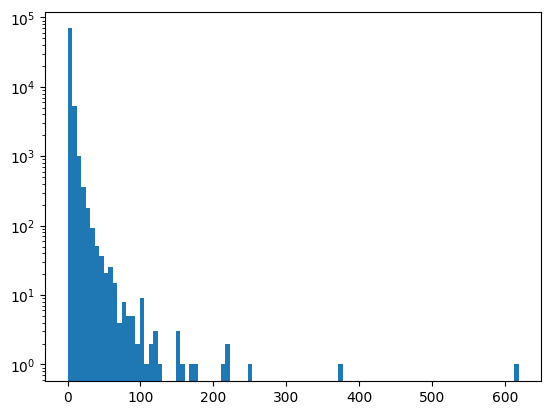

In [12]:
from rbm_torch.utils import data_prep as dp
dp.quick_hist(pig_avg.Final_Fold_Avg.to_numpy())